In [1]:
import pandas as pd
from random import randrange
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm

In [2]:
#size of lists of names provided is only limit to size of family tree/web
#process time does increase linearly without some optimising of what can loosely be called the fitness function

male_names = []
for i in open('male_names.txt', 'r').readlines():
    male_names.append(i[:-2])

female_names = []
for i in open('female_names.txt', 'r').readlines():
    female_names.append(i[:-2])

In [3]:
#could be more robust apporach to recursive familial relation functions
#individuals as entities have two attributes: mother and father
#all relations can bedefined recursively from mother/father attributes
#cousins becomes problematic for non-strictly hierarichal trees
#i beleive increasing the number of generations does not add any new logical challenges

def relative(name):
    
    members = []
    for i in G[name]:
        members.append(i)
    
    member_tag = []
    for i in members:
        for j in G[name][i]:
            member_tag.append((i,G[name][i].get(j).get('relation')))
            
    name_df_row = df[df['name']==name].index.item()
    mother = df.iloc[name_df_row].get('mother')
    father = df.iloc[name_df_row].get('father')
    
    mate = []
    offspring = []
    for i in member_tag:
        if i[1] == 'mate':
            mate.append(i[0])
        if i[1] == 'offspring':
            offspring.append(i[0])
            
    daughter = []
    son = []
    for i in offspring:
        row = df[df['name']==i].index.item()
        if df.iloc[row].get('sex') == 'F':
            daughter.append(i)
        if df.iloc[row].get('sex') == 'M':
            son.append(i)
        
    return {'mother':mother,
            'father':father,
            'mate':mate,
            'offspring':offspring,
            'daughter':daughter,
            'son':son}

def grandParent(name):
    
    mother = relative(name).get('mother')
    father = relative(name).get('father')
    
    if mother is None:
        mother_mother = None
        mother_father = None
    else:
        mother_mother = relative(mother).get('mother')
        mother_father = relative(mother).get('father')
    
    if father is None:
        father_mother = None
        father_father = None
    else:
        father_mother = relative(father).get('mother')
        father_father = relative(father).get('father')
    
    grandmother = [mother_mother,father_mother]
    grandfather = [mother_father,father_father]
    
    grandmother = list(filter(None, grandmother)) 
    grandfather = list(filter(None, grandfather)) 
    
    return {'grandmother':grandmother,
            'grandfather':grandfather}

def grandChild(name):
    
    offspring = relative(name).get('offspring')
    
    grandchild = []
    for i in offspring:
        grandchild.extend(relative(i).get('offspring'))
    grandchild = list(set(grandchild))

    granddaughter = []
    grandson = []
    for i in grandchild:
        row = df[df['name']==i].index.item()
        if df.iloc[row].get('sex') == 'F':
            granddaughter.append(i)
        if df.iloc[row].get('sex') == 'M':
            grandson.append(i)
    
    return {'granddaughter':granddaughter,
            'grandson':grandson}

def sibling(name):
    
    parent = [relative(name).get('mother'), relative(name).get('father')]
    parent = list(filter(None, parent))
    
    if parent == []:
        return {'sister':[],
                'brother':[]}
    
    sibling = []
    for i in parent:
        sibling.extend(relative(i).get('offspring'))
        
    sibling = list(set(sibling))
    sibling.remove(name)

    sister = []
    brother = []
    for i in sibling:
        row = df[df['name']==i].index.item()
        if df.iloc[row].get('sex') == 'F':
            sister.append(i)
        if df.iloc[row].get('sex') == 'M':
            brother.append(i)
    
    return {'sister':sister,
            'brother':brother}

def auntUncle(name):
    
    parent = [relative(name).get('mother'), relative(name).get('father')]
    parent = list(filter(None, parent))
    
    if parent == []:
        return {'aunt':[],
                'uncle':[]}

    parent_sibling = []
    for i in parent:
        parent_sibling.extend(sibling(i).get('sister'))
        parent_sibling.extend(sibling(i).get('brother'))
    
    parent_sibling = list(set(parent_sibling))
        
    aunt = []
    uncle = []
    for i in parent_sibling:
        row = df[df['name']==i].index.item()
        if df.iloc[row].get('sex') == 'F':
            aunt.append(i)
        if df.iloc[row].get('sex') == 'M':
            uncle.append(i)
            
    return {'aunt':aunt,
            'uncle':uncle}    

def nieceNephew(name):
    
    siblings = sibling(name).get('sister') + sibling(name).get('brother')
    if siblings == []:
        return {'niece':[],
               'nephew':[]}
    
    sibling_offspring = []
    for i in siblings:
        sibling_offspring.extend(relative(i).get('offspring'))
        
    if sibling_offspring == []:
        return {'niece':[],
               'nephew':[]}
    niece = []
    nephew = []
    for i in sibling_offspring:
        row = df[df['name']==i].index.item()
        if df.iloc[row].get('sex') == 'F':
            niece.append(i)
        if df.iloc[row].get('sex') == 'M':
            nephew.append(i)
    
    return {'niece':niece,
           'nephew':nephew} 

In [4]:
#function to add family member
#randomly selects mother and father from previous family mmebers and randomly assigns sex
#possibility of adding weights according to indiviudal "fitness" for reproduction

def geneSelection(female_count,male_count,family):
    '''add new family member with randomly assigned mother, father and sex'''
    
    women = family['sex'] == 'F'
    men = family['sex'] == 'M'

    women_list = family[women]['name'].tolist()
    men_list = family[men]['name'].tolist()
    
    if randrange(2) == 0:
        sex = 'F'
        name = female_names[female_count - 1]
    else:
        sex = 'M'
        name = male_names[male_count - 1]
    
    #can include possibility of immaculate conception, whatever the male alternative is, or a newfamily member with no genetic history
    if randrange(10) == 11:
        mother = None
    else:
        index = randrange(len(women_list))
        mother = women_list[index]
    
    if randrange(10) == 11:
        father = None
    else:
        index = randrange(len(men_list))
        father = men_list[index]
    
    return {'name':name,'sex':sex,'mother':mother,'father':father}

In [5]:
#generate new tree from prime movers Eve and Adam
#new_offspring defines number of additional family members
#returns all family members as dataframe and networkx graph

def newTree():
    '''generate new family tree'''
    
    new_offspring = 8
    female_count = 1
    male_count = 1
    
    family = pd.DataFrame({'name':['Eve','Adam'],
                           'sex':['F','M'],
                           'mother':[None,None],
                           'father':[None, None]
                          })
    
    for i in range(new_offspring):
        baby = geneSelection(female_count,male_count,family)
        family = family.append(baby,ignore_index=True)
        
        if baby.get('sex') == 'F':
            female_count += 1
        else:
            male_count += 1
            
    df = family
    o_p_edges = []
    p_o_edges = []
    for i in range(df.shape[0]):
        if df.loc[i].get('mother') is not None:
            o_p_edges.append((df.loc[i].get('name'),df.loc[i].get('mother')))
            p_o_edges.append((df.loc[i].get('mother'),df.loc[i].get('name')))
        if df.loc[i].get('father') is not None:
            o_p_edges.append((df.loc[i].get('name'),df.loc[i].get('father')))
            p_o_edges.append((df.loc[i].get('father'),df.loc[i].get('name')))
        
    mate_edges = []
    for i in range(df.shape[0]):
        if df.loc[i].get('mother') is not None and df.loc[i].get('father') is not None:
            mate_edges.append((df.loc[i].get('mother'),df.loc[i].get('father')))
            mate_edges.append((df.loc[i].get('father'),df.loc[i].get('mother')))

    mate_edges = list(set(mate_edges))       
        
    G = nx.MultiDiGraph()
    G.add_nodes_from(df['name'])
    G.add_edges_from(o_p_edges,relation='parent')
    G.add_edges_from(p_o_edges,relation='offspring')
    G.add_edges_from(mate_edges,relation='mate')
            
    return family, G

In [6]:
def vizTree(family):
    '''visualise family tree with colour coded edges with arrows lineage'''
    
    df = family
    offspring_ii = []
    mate_ii = []
    for i in range(df.shape[0]):
        if df.loc[i].get('mother') is not None:
            offspring_ii.append([df.loc[i].get('mother'),df.loc[i].get('name')])
        if df.loc[i].get('father') is not None:
            offspring_ii.append([df.loc[i].get('father'),df.loc[i].get('name')])
        if df.loc[i].get('mother') is not None and df.loc[i].get('father') is not None:    
            mate_ii.append([df.loc[i].get('mother'),df.loc[i].get('father')])
        
    offspring_mate = []
    for i in offspring_ii:
        if i in mate_ii or [i[1],i[0]] in mate_ii:
            offspring_mate.append(i)
        
    offspring_mate_inv = []
    for i in offspring_mate:
        offspring_mate_inv.append([i[1],i[0]])

    offspring = []
    for i in offspring_ii:
        if i not in offspring_mate and i not in offspring_mate_inv:
            offspring.append(i)

    mate = []     
    for i in mate_ii:
        if i not in offspring_mate and i not in offspring_mate_inv:
            mate.append(i)
            
    VG = nx.DiGraph()
    plt.figure(figsize=(8,8))
    #edges
    VG.add_edges_from(offspring_mate+offspring+mate)

    pos = nx.circular_layout(VG)
    nx.draw_networkx_nodes(VG, pos, cmap=plt.get_cmap('jet'), 
                           node_color = 'yellow', node_size = 350)

    nx.draw_networkx_labels(VG, pos)

    nx.draw_networkx_edges(VG, pos,edgelist=offspring_mate, edge_color='r',arrows=True)
    nx.draw_networkx_edges(VG, pos, edgelist=offspring, edge_color='b', arrows=True)
    nx.draw_networkx_edges(VG, pos, edgelist=mate,edge_color='g', arrows=False)

    red_patch = mpatches.Patch(color='red', label='offspring and mate')
    blue_patch = mpatches.Patch(color='blue', label='offspring')
    green_patch = mpatches.Patch(color='green', label='mate')
    plt.legend(handles=[red_patch,blue_patch,green_patch])
    plt.axis('off')

    plt.show()

In [7]:
#fitness function assessing family tree for desired relationships
#loops through all pairs and returns intersect if found
#could be optimised be limiting indiviudals to only potential candidate pairs

def assessTree(list):
    
    command = ''
    for k in list:
        string = 'j in '+ k + ' and '
        command += string
    command = command[:-5]
        
    for i in family['name']:
        grandmother = grandParent(i).get('grandmother')
        grandfather = grandParent(i).get('grandfather')
        mother = [relative(i).get('mother')]
        father = [relative(i).get('father')]
        aunt = auntUncle(i).get('aunt')
        uncle = auntUncle(i).get('uncle')
        sister = sibling(i).get('sister')
        brother = sibling(i).get('brother')
        daughter = relative(i).get('daughter')
        son = relative(i).get('son')
        niece = nieceNephew(i).get('niece')
        nephew = nieceNephew(i).get('nephew')
        granddaughter = grandChild(i).get('granddaughter')
        grandson = grandChild(i).get('grandson')
        
        relationships = []
        for j in family['name']:
            if eval(command):
                relationships.append((i,j))
                break
        if relationships != []:
            break
            
    return relationships

 12%|█▏        | 6/50 [00:17<02:05,  2.85s/it]

[('John', 'Michael')]


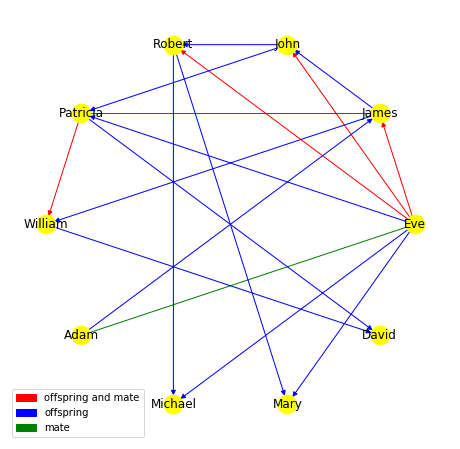

In [8]:
#define challenge and run x many iterations to compute
#if relationships are found, returns viz of complete family tree and relation pair
#could improve result with refined viz only to family mmebers relevant to challenge

challenge = ['grandson','brother','uncle']

iterations = 50
for i in tqdm(range(iterations)):
    tree = newTree()
    family = tree[0]
    df = family
    G = tree[1]
    
    result = assessTree(challenge)
    if result !=[]:
        found = True
        break

if found == True:        
    print(result)
    vizTree(df)